# MS SSIM
----

This notebook begins the creation of the data sets necessary to train the MS_SSIM network. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
np.set_printoptions(threshold=np.nan)
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

In [4]:
def calculate_contrast(window_orig, window_recon):
    '''
    calculates the contrast metric for a given window of two images
    '''
    k_2, L = 0.03, 255
    c_2 = (L*k_2)**2
    
    orig_data, recon_data = window_orig.flatten(), window_recon.flatten()
    var_x, var_y = np.var(recon_data), np.var(orig_data)
    
    num = 2*np.sqrt(var_x)*np.sqrt(var_y) + c_2
    den = var_x + var_y + c_2
    
    return num/den

def calculate_structure(window_orig, window_recon):
    '''
    calculates the structure metric for a given window of two images
    '''
    k_2, L = 0.03, 255
    c_2 = (L*k_2)**2
    c_3 = c_2 / 2
    
    orig_data, recon_data = window_orig.flatten(), window_recon.flatten()
    std_x, std_y = np.std(recon_data), np.std(orig_data)
    covar = np.cov(orig_data, recon_data)[0][1]
    
    num = covar + c_3
    den = std_x * std_y + c_3
    
    return num/den

Now that we have the metrics in place we can load the data an run them iteratively at each size of the images.

In [5]:
image_dim, result_dim, filter_dim = 96, 86, 11
train_size, test_size = 500, 140

In [6]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500_raw = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500_raw = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140_raw = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140_raw = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

In [7]:
# reshape
orig_500 = np.reshape(orig_500_raw.values, (train_size, image_dim, image_dim))
recon_500 = np.reshape(recon_500_raw.values, (train_size, image_dim, image_dim))
orig_140 = np.reshape(orig_140_raw.values, (test_size, image_dim, image_dim))
recon_140 = np.reshape(recon_140_raw.values, (test_size, image_dim, image_dim))

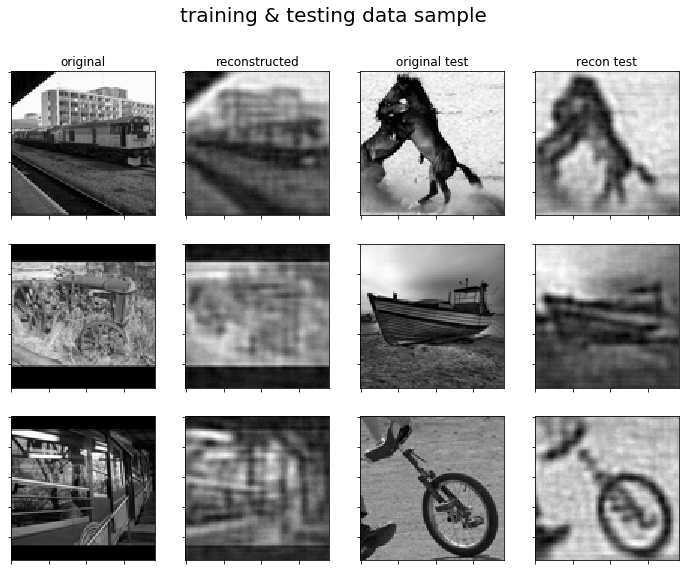

In [12]:
# make sure pictures look right
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    index = np.random.randint(140)
    axarr[i,0].imshow(orig_500[index,:,:], cmap='gray')
    axarr[i,1].imshow(recon_500[index,:,:], cmap='gray')
    axarr[i,2].imshow(orig_140[index,:,:], cmap='gray')
    axarr[i,3].imshow(recon_140[index,:,:], cmap='gray')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[0,2].set_title('original test')
axarr[0,3].set_title('recon test')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('training & testing data sample', size=20)
# plt.savefig('tt_data_sample.png')
plt.show()

data looks good. now we can get the contrast and structures for the full size images.

In [13]:
def image_contrast(orig_im, recon_im):
    '''
    gets the contrast for each patch of a set of images.
    '''
    contrast_res = []
    number_windows = image_dim - filter_dim + 1
    for i in range(number_windows):
        for j in range(number_windows):
            orig_window = orig_im[i:i+11, j:j+11]
            recon_window = recon_im[i:i+11, j:j+11]
            temp = calculate_contrast(orig_window, recon_window)
            contrast_res.append(temp)
    return np.reshape(contrast_res, (result_dim, result_dim))

def image_structure(orig_im, recon_im):
    '''
    gets the structure for each patch of a set of images.
    '''
    structure_res = []
    number_windows = image_dim - filter_dim + 1
    for i in range(number_windows):
        for j in range(number_windows):
            orig_window = orig_im[i:i+11, j:j+11]
            recon_window = recon_im[i:i+11, j:j+11]
            temp = calculate_structure(orig_window, recon_window)
            structure_res.append(temp)
    return np.reshape(structure_res, (result_dim, result_dim))

Lets test these functions on a couple images and see how they look.

In [21]:
contrast_res, structure_res = [], []
indeces = []
for ii in range(3):
    index = np.random.randint(140)
    indeces.append(index)
    temp_im_orig = orig_500[index,:,:]
    temp_im_recon = recon_500[index,:,:]
    contrast_res.append(image_contrast(temp_im_orig, temp_im_recon))
    structure_res.append(image_structure(temp_im_orig, temp_im_recon))
contrast_res = np.asarray(contrast_res)
structure_res = np.asarray(structure_res)

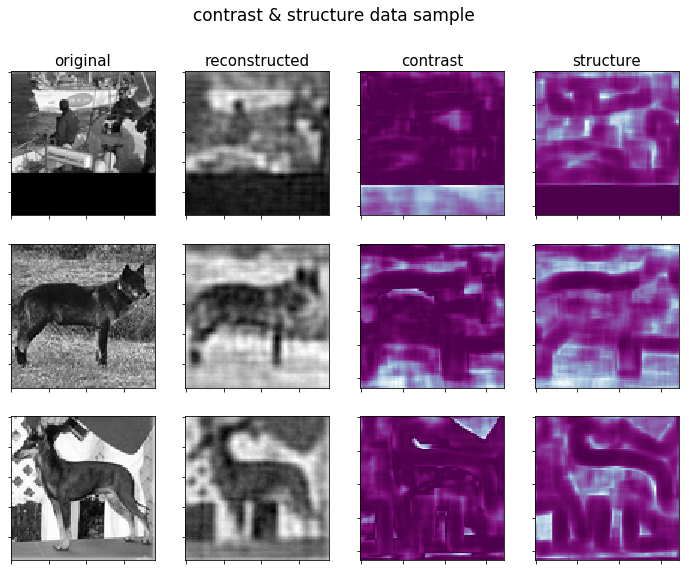

In [28]:
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    axarr[i,0].imshow(orig_500[indeces[i],:,:], cmap='gray')
    axarr[i,1].imshow(recon_500[indeces[i],:,:], cmap='gray')
    axarr[i,2].imshow(contrast_res[i,:,:], cmap='BuPu')
    axarr[i,3].imshow(structure_res[i,:,:], cmap='BuPu')

axarr[0,0].set_title('original', size=15)
axarr[0,1].set_title('reconstructed', size=15)
axarr[0,2].set_title('contrast', size=15)
axarr[0,3].set_title('structure', size=15)
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('contrast & structure data sample', size=17)
plt.savefig('contrast_structure_data_sample.png')
plt.show()